In [17]:
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution
from tqdm import tqdm
from matplotlib.pyplot import cm

In [18]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

In [19]:
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [20]:
def double_gaussian(x, mu, sig, A, mu2, sig2, A2):
    return gaussian(x, mu, sig, A)+gaussian(x, mu2, sig2, A2)

In [310]:
array = pd.read_csv('../data/test_array.csv') #spaces in csv file will make df object type and not float64
array = array.loc[array['Species'].str.endswith('S I')]

In [311]:
guess = array.to_numpy()
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

Let's use the method of least_squares() with bounds instead of least_sq().

In [312]:
import scipy.optimize as sop
import numpy as np
def ftest(x):
    x,y,z = x
    data = np.array([3.65,2.41,1.59])# arbitrary & just for testing
    model = np.array([x**2,y**2,z**2])# arbitrary & just for testing
    residuals = data - model 
    return residuals
def ftest2(x):
    return sum(ftest(x)**2)# to ask fmin to minimize the chi2 but it can be anything
p0 = np.array([1,2,3])# arbitrary & just for testing
opt = sop.fmin(ftest2, p0)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 73
         Function evaluations: 131


In [319]:
C = np.delete(guess, 1, 1)

In [320]:
test = C.astype('float64')
test = np.delete(guess, 1, 1)
test = test.astype(dtype=np.float64)

In [308]:
x = 46 #26, 27, are the biggest problem file, show 15 to see overlap in fit and data
# 13,14,15, 47 look like they are shifted to the right
# fix 22, 29, 32, 33, 37, 38, 43, 44, 46 amp guess
# check 39 with double gauss
# where is 40 supposed to be
# 49, 50, 51 is on part with no data
guess1 = test[x]
guess2 = np.hstack((guess1, test[x+1]))
#guess1 = [1.389154e+03, 1.300000e-01, 0.01] #manually input guess where sigma is smaller

errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2
errfunc2 = lambda p, x, y: (double_gaussian(x, *p) - y)**2
opt = optimize.least_squares(errfunc1, guess1, args=(wl, flux/10**-13), bounds=([guess1[0]-0.5, 0, 0],
                                                                        [guess1[0]+0.5, np.inf, np.inf]))
nob = optimize.least_squares(errfunc1, guess1, args=(wl, flux/10**-13))
opt2 = optimize.least_squares(errfunc2, guess2, args=(wl, flux/10**-13), bounds=([guess2[0]-0.5, 0, 0,
                                                                         guess2[3]-0.5, 0, 0], [guess2[0]+0.5,
                                                                         np.inf, np.inf, guess2[3]+0.5, np.inf, np.inf]))

guess1, opt['x'], nob['x'], guess2, opt2['x']

(array([1.42503e+03, 2.30000e-01, 2.00000e-03]),
 array([1.42512706e+03, 1.92534896e-01, 6.51195854e-02]),
 array([1.42522977e+03, 3.02075234e-01, 5.03608836e-02]),
 array([1.425030e+03, 2.300000e-01, 2.000000e-03, 1.425219e+03,
        2.300000e-01, 2.000000e-03]),
 array([1.42503183e+03, 1.73012127e-01, 4.11496283e-02, 1.42521856e+03,
        2.16850059e-01, 2.66036493e-02]))

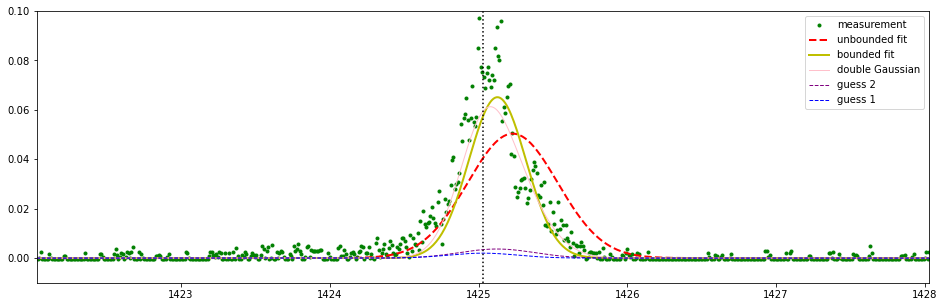

In [309]:
plt.figure(figsize=(16, 5))
plt.plot(wl, flux/10**-13,'g.', label='measurement')
plt.plot(wl, gaussian(wl, *nob['x']),
    lw=2, c='red', ls='--', label='unbounded fit')
plt.plot(wl, gaussian(wl, *opt['x']),
    lw=2, c='y', label='bounded fit')
plt.plot(wl, double_gaussian(wl, *opt2['x']),
    lw=1, c='pink', label='double Gaussian')
plt.plot(wl, double_gaussian(wl, *guess2),
    lw=1, c='purple', ls='--', label='guess 2')
plt.plot(wl, gaussian(wl, *guess1),
    lw=1, c='b', ls='--', label='guess 1')
plt.axvline(guess1[0], color = 'black', linestyle = 'dotted')
plt.ylim(-0.01,0.1)
plt.xlim(guess1[0]-3,guess1[0]+3)
plt.legend(loc='best')